In [1]:
from abenc_ph_mj18 import PH_ABE, mat_math, Inner_Product
from charm.toolbox.pairinggroup import PairingGroup, ZR, G1, G2, GT, pair
from charm.toolbox.ABEnc import ABEnc
from nizk import NIZK
from benchmark import Benchmark
from collections import defaultdict 
import time
import matplotlib.pyplot as plt
import numpy as np

## Benchmarking

In [2]:
ben = Benchmark(PairingGroup('MNT224'))
datasets = defaultdict(str)

In [3]:
xs = range(5,101,5)
datasets = ben.benchmark_scheme(2, xs, datasets)
datasets = ben.benchmark_scheme(3, xs, datasets)

---------------- 5 -----------------------
Each AA's setup:  0.041933631896972655
Each AA's extra cost:  0.3464925289154053
Adv's total cost:  0.23118877410888672
---------------- 10 -----------------------
Each AA's setup:  0.04117560386657715
Each AA's extra cost:  0.6564440727233887
Adv's total cost:  0.3907179832458496
---------------- 15 -----------------------
Each AA's setup:  0.04089008967081706
Each AA's extra cost:  0.9620964527130127
Adv's total cost:  0.5584421157836914
---------------- 20 -----------------------
Each AA's setup:  0.04103564023971558
Each AA's extra cost:  1.292576551437378
Adv's total cost:  0.756148099899292
---------------- 25 -----------------------
Each AA's setup:  0.04101116180419922
Each AA's extra cost:  1.5918159484863281
Adv's total cost:  0.9592990875244141
---------------- 30 -----------------------
Each AA's setup:  0.04121279716491699
Each AA's extra cost:  1.909235954284668
Adv's total cost:  1.1466708183288574
---------------- 35 ----------

In [5]:
sp_xs = range(5,102,8)
datasets = ben.benchmark_scheme(5, sp_xs, datasets)
datasets = ben.benchmark_scheme(10, sp_xs, datasets)

---------------- 5 -----------------------
Each AA's setup:  0.11345458030700684
Each AA's extra cost:  0.7398226261138916
Adv's total cost:  0.46080684661865234
---------------- 13 -----------------------
Each AA's setup:  0.112747834278987
Each AA's extra cost:  1.816399097442627
Adv's total cost:  0.9840612411499023
---------------- 21 -----------------------
Each AA's setup:  0.11215004466828846
Each AA's extra cost:  2.924755811691284
Adv's total cost:  1.5460033416748047
---------------- 29 -----------------------
Each AA's setup:  0.11141668517014076
Each AA's extra cost:  3.9455111026763916
Adv's total cost:  2.1826717853546143
---------------- 37 -----------------------
Each AA's setup:  0.11140959327285355
Each AA's extra cost:  5.024169445037842
Adv's total cost:  2.8892149925231934
---------------- 45 -----------------------
Each AA's setup:  0.11157053311665853
Each AA's extra cost:  6.063941955566406
Adv's total cost:  3.6657612323760986
---------------- 53 --------------

## Ploting

In [149]:
def plot_linestyle(ks, xs, ys, sp_xs, sp_ys, labels):
    # Plotting:
    plt.figure(figsize=(10,6))

    # List of linestyles for variation. You can extend this if needed.
    linestyles = ['-', '--', ':']
    sp_linestyles = ['-.', ':', '-']
    
    # Plotting the regular data points for each k_value
    for y, label, style in zip(ys, labels, linestyles):
        #print (xs, y)
        plt.plot(xs, y, label=f'{label} with k={ks[0]}', linestyle=style)

    # Plotting the special cases
    for y, label, style in zip(sp_ys, labels, sp_linestyles):
        plt.plot(sp_xs, y, linestyle=style, marker='o', label=f'{label} with k={ks[1]}')

    vlines_x = [45, 85]  # example x-coordinates for the vertical lines

    for vx in vlines_x:
        plt.axvline(x=vx, color='gray', linestyle='--', alpha=0.7)  # draw vertical line
        
        if vx in xs:  # If vx is a value in xs, get its intersection with the regular plots
            idx = xs.index(vx)
            for y in ys:
                rounded_y = round(y[idx], 2)
                #plt.scatter(vx, rounded_y, color='red', zorder=5)
                plt.annotate(f'({vx}, {rounded_y})', (vx, rounded_y), textcoords="offset points", xytext=(0,10), ha='center')
        
        if vx in sp_xs:  # If vx is a value in sp_x, get its intersection with the special plots
            idx_sp = sp_xs.index(vx)
            for y in sp_ys:
                rounded_y_sp = round(y[idx_sp], 2)
                #plt.scatter(vx, rounded_y_sp, color='blue', zorder=5)
                plt.annotate(f'({vx}, {rounded_y_sp})', (vx, rounded_y_sp), textcoords="offset points", xytext=(0,10), ha='center')

    # Setting labels, title, legend, etc.
    plt.xlabel('Size of attribute authority')
    plt.ylabel('Elapsed Time (seconds)')
    #plt.title('Performance based on k-LIN Assumption Size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()


In [150]:
ks = [2,5]

xs = range(5,101,5)
ys = []
ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])
ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[0])]['seq']])
ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(xs, datasets[str(ks[0])]['seq'])])

#ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[0])]['seq']])

#ys.append([d['total'] for d in datasets['3']['seq']])

sp_xs = range(5,102,8)
sp_ys = []
sp_ys.append([d['total'] for d in datasets[str(ks[1])]['seq']])
sp_ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[1])]['seq']])
sp_ys.append([(d['auth'] + d['keygen'])/i for i,d in zip(sp_xs, datasets[str(ks[1])]['seq'])])

#sp_ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[1])]['seq']])



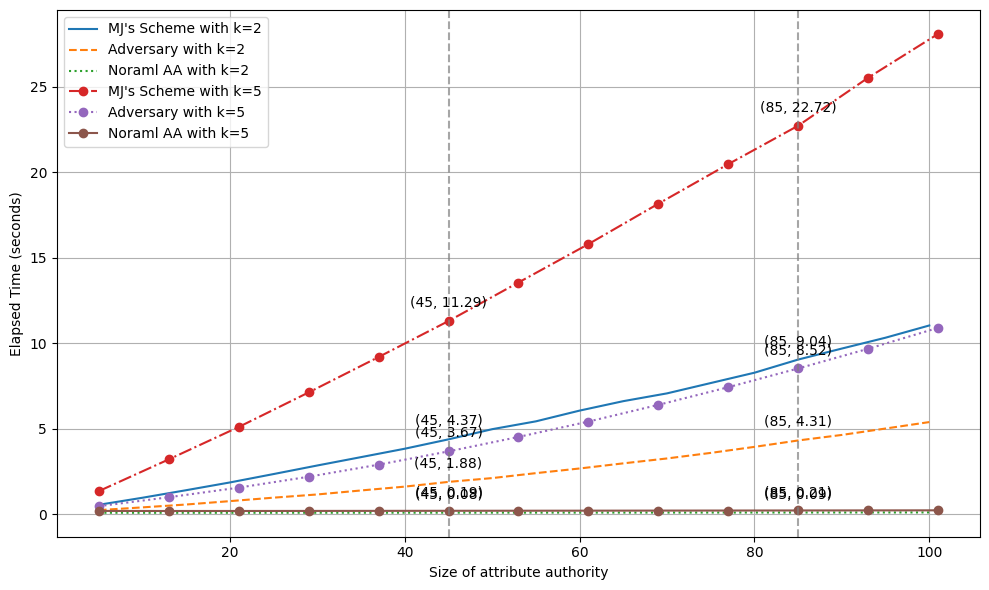

In [151]:
plot_linestyle(ks, xs, ys, sp_xs, sp_ys, ["MJ's Scheme", "Adversary", "Noraml AA"])

### Comparsion

In [152]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comp(ks, xss, ys, comp_ys, labels):
    plt.figure(figsize=(10, 6))

    linestyles = ['-', '-.','--', ':']

    # Plotting the subsequent data sets and calculating differences for Compare Set 1
    for i, k, y, y_,  style in zip(range(len(ks)), ks, ys, comp_ys, linestyles):
        plt.plot(xss[i], y, label=f'CP{i}: {labels[0]} with k={k}', linestyle=style)
        plt.plot(xss[i], y_, label=f'CP{i}: {labels[1]} with k={k}', linestyle=style, alpha=0.7)

        plt.fill_between(xss[i], y, y_, color='gray', alpha=0.2)

        diff = (np.array(y_) - np.array(y)) / np.array(y) * 100
        avg_increase = np.mean(diff)

        # Finding the midpoint for annotation
        mid_index = len(xss[i]) // 2  # Finding the index at the middle of the dataset
        mid_x = xss[i][mid_index]  # X-coordinate at the midpoint
        mid_y = (y[mid_index] + y_[mid_index]) / 2  # Average Y-coordinate at the midpoint

        plt.annotate(f'Avg. increase: {avg_increase:.2f}%', xy=(mid_x, mid_y), textcoords='data', ha='center', size= 25)

    plt.xlabel('Size of attribute authority')
    plt.ylabel('Time Cost (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.title(title)
    plt.show()


In [153]:
ks = [2,5]

xs = range(5,101,5)
comp_xs = range(5,102,8)
ys = []
comp_ys = []
ys.append([d['total'] for d in datasets[str(ks[0])]['seq']])
#ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[0])]['seq']])
comp_ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[0])]['seq']])


ys.append([d['total'] for d in datasets[str(ks[1])]['seq']])
#sp_ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[1])]['seq']])
comp_ys.append([d['total'] + d['prove'] + d['verify'] for d in datasets[str(ks[1])]['seq']])

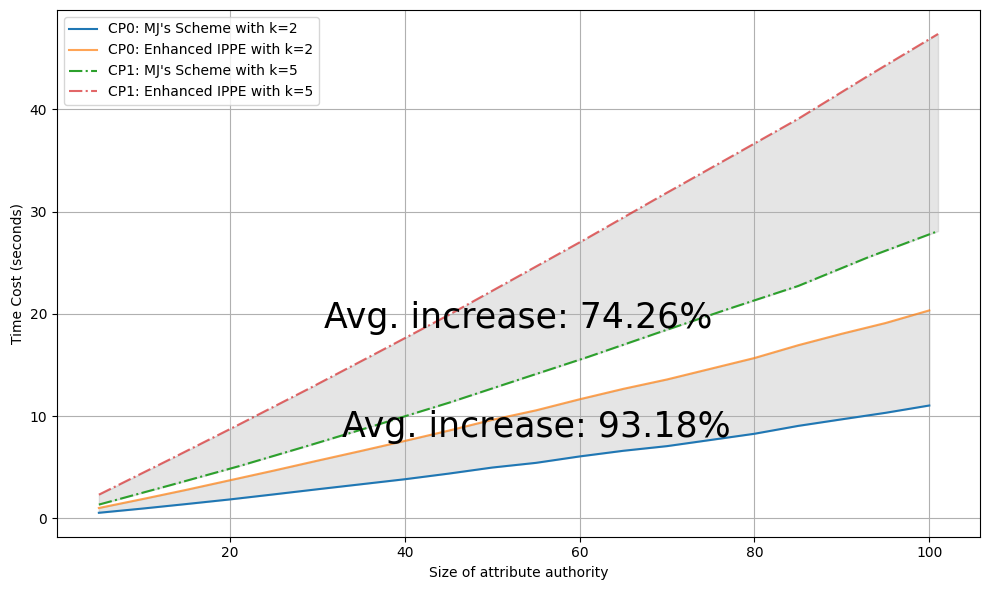

In [148]:
plot_comp(ks, [xs, comp_xs], ys, comp_ys, ["MJ's Scheme", 'Enhanced IPPE'])#, "Compare Cost for Original Scheme and our Enhanced IPPE")

In [154]:
ys = []
comp_ys = []
ks = [2,5]
ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[0])]['seq']])
comp_ys.append([d['prove'] + d['verify'] for d in datasets[str(ks[0])]['seq']])


ys.append([d['ad_setup'] + d['ad_keygen'] + d['ad_decrypt'] for d in datasets[str(ks[1])]['seq']])
comp_ys.append([d['prove'] + d['verify'] for d in datasets[str(ks[1])]['seq']])

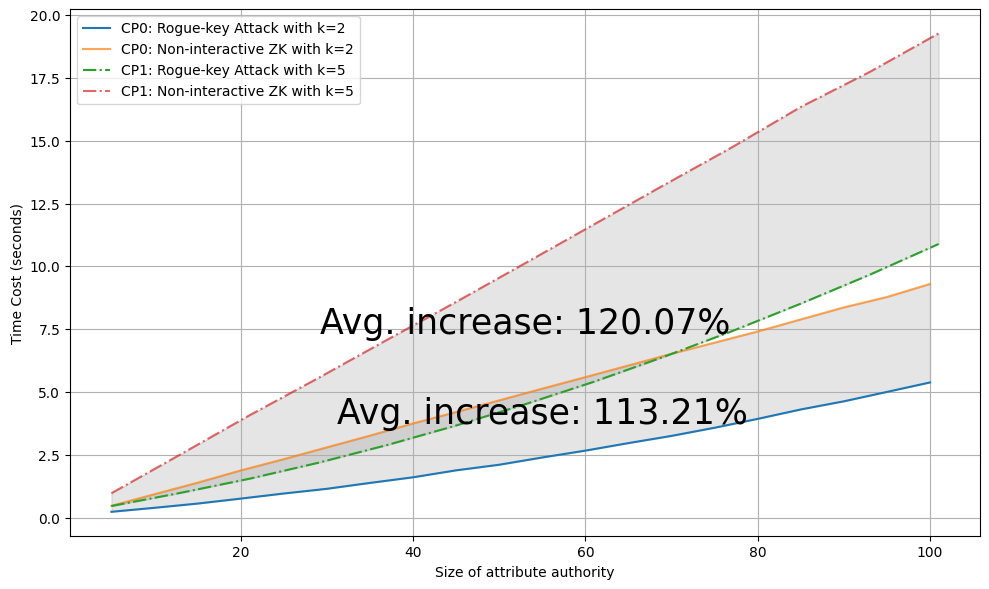

In [155]:
plot_comp(ks, [xs, comp_xs], ys, comp_ys, ['Rogue-key Attack','Non-interactive ZK'])#, "Compare Cost for Rogue-key Attack and its Defense")